In [27]:
import matplotlib
import seaborn
import pandas
import networkx
import tqdm
import gzip
import igraph
import itertools

import statsmodels
import scipy.stats

from collections import Counter, OrderedDict

%matplotlib inline

seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')

In [28]:
ecosystems = ['cran', 'pypi', 'npm']

COLORS = {ecos: seaborn.color_palette()[i] for i, ecos in enumerate(ecosystems)}
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (10, 3)
SHOW_TITLE = False

def savefig(fig, name):
    # Uncomment next line to disable export
    # return
    return fig.savefig('../figures/{}.pdf'.format(name), bbox_inches='tight')

In [29]:
graphs = OrderedDict()
df_all_packages = OrderedDict()
df_packages = OrderedDict()
df_all_deps = OrderedDict()
df_deps = OrderedDict()
df_sizes = OrderedDict()

for ecos in ecosystems:
    with gzip.GzipFile('../../{}/data/packages.csv.gz'.format(ecos)) as f:
        packages = pandas.read_csv(f, index_col=[0,1], parse_dates=['time'])
    with gzip.GzipFile('../../{}/data/deps.csv.gz'.format(ecos)) as f:
        deps = pandas.read_csv(f)

    try:
        sizes = pandas.read_csv('../../{}/data/sizes.csv'.format(ecos), index_col=['package', 'version'])
    except OSError as e:
        print(e)
        sizes = pandas.DataFrame([], columns=['package', 'version', 'size']).set_index(['package', 'version'])
        
    print(ecos)
    print(len(packages.groupby(level=0)), 
          'packages,',
          len(packages), 'versions and',
          len(deps), 'dependencies')
    print('from', min(packages.time), 'to', max(packages.time))
        
    df_all_packages[ecos] = packages
    df_all_deps[ecos] = deps
    df_sizes[ecos] = sizes
    
    # Take latest version of each package
    packages = packages.dropna().sort_values('time').groupby(level=0, sort=False).tail(1)
    deps = packages.merge(deps, how='inner', left_index=True, right_on=['package', 'version']).dropna()

    # Merge size info
    packages = packages.merge(sizes, how='left', left_index=True, right_index=True)
    
    print(len(deps), 'dependencies kept')
    print('versions from', packages.time.min(), 'to', packages.time.max())
    print()
    
    # Filter out dependencies that are not registered packages
    deps = packages.reset_index().merge(deps, how='inner', left_on='package', right_on='dependency', suffixes=('_2', ''))
    
    df_packages[ecos] = packages
    df_deps[ecos] = deps
    
    # Construct graph
    graph = igraph.Graph(directed=True)
    graph.add_vertices(packages.index.get_level_values('package'))
    graph.vs['time'] = packages['time']
    graph.vs['version'] = packages.index.get_level_values('version')
    graph.vs['size'] = packages['size']
    
    edges = [(row.package, row.dependency) for row in deps[['package', 'dependency']].itertuples()]
    graph.add_edges(edges)
    
    graphs[ecos] = graph
    

File b'../../cran/data/sizes.csv' does not exist
cran
9568 packages, 57530 versions and 203265 dependencies
from 1997-10-08 19:56:17 to 2016-04-26 20:52:26
9337 dependencies kept
versions from 1997-10-08 19:56:17 to 2016-04-26 20:52:26

pypi
82134 packages, 508373 versions and 154833 dependencies
from 2005-03-21 15:59:25 to 2016-06-25 00:11:15
19172 dependencies kept
versions from 2005-04-18 14:47:04 to 2016-06-25 00:11:15

npm
317159 packages, 1927750 versions and 7692501 dependencies
from 1970-01-01 00:00:00 to 2016-06-28 14:35:28.717000
729059 dependencies kept
versions from 2010-12-19 09:45:59.546000 to 2016-06-28 14:35:28.717000



""" Uncomment this cell to get a list (in npm-download.txt) of package/version names from NPM. 
This cell helps us to compute the list of packages we need to download in order to get their size. """

df = df_packages['npm']
df = df.reset_index()[['package', 'version']]
url = 'https://registry.npmjs.org/{package}/-/{package}-{version}.tgz'
with open('npm-download.txt', 'w') as f:
    for t in df.itertuples():
        f.write(url.format(package=t.package, version=t.version) + '\n')

## Overview

In [30]:
for ecos, df in df_all_packages.items():
    print(ecos)
    for year in [2014, 2015, 2016]:
        selected = df[df['time'].dt.year == year]
        print('Updates in {}: {}'.format(year, len(selected)))
        
        selected = df.groupby(level=0).min()
        selected = selected[selected['time'].dt.year == year]
        print('New packages in {}: {}'.format(year, len(selected)))

cran
Updates in 2014: 7250
New packages in 2014: 1378
Updates in 2015: 8140
New packages in 2015: 1660
Updates in 2016: 3076
New packages in 2016: 631
pypi
Updates in 2014: 91785
New packages in 2014: 13564
Updates in 2015: 131072
New packages in 2015: 17818
Updates in 2016: 83905
New packages in 2016: 10787
npm
Updates in 2014: 403907
New packages in 2014: 69043
Updates in 2015: 711317
New packages in 2015: 113613
Updates in 2016: 541192
New packages in 2016: 82293


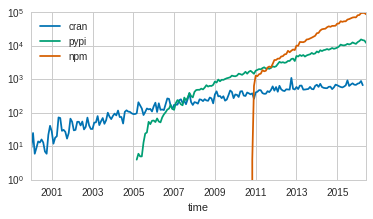

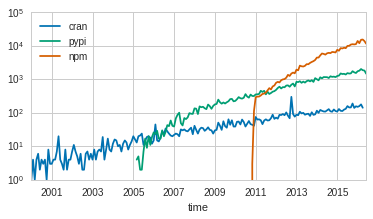

In [31]:
fig_v, ax_v = matplotlib.pyplot.subplots()
fig_p, ax_p = matplotlib.pyplot.subplots()

fig_v.set_size_inches(FIG_SIZE)
fig_p.set_size_inches(FIG_SIZE)

if SHOW_TITLE:
    ax_v.set_title('New versions by month (log scale)')
    ax_p.set_title('New packages by month (log scale)')

for ecos, all_packages in df_all_packages.items():
    df1 = (all_packages
            .set_index('time')
            .assign(n=1)
            .resample('1M')
            .sum()
            .fillna(0)
            .rename(columns={'n': ecos})
          )
    df1.plot(ax=ax_v, logy=True)
    
    df2 = (all_packages
            .groupby(level=0)
            .min()
            .set_index('time')
            .assign(n=1)
            .resample('1M')
            .sum()
            .fillna(0)
            .rename(columns={'n': ecos})
          )
    df2.plot(ax=ax_p, logy=True)

ax_v.set_xlim(pandas.to_datetime('2000-01-01'))
ax_p.set_xlim(pandas.to_datetime('2000-01-01'))

savefig(fig_v, 'evol_versions')
savefig(fig_p, 'evol_packages')

In [32]:
from statsmodels import regression

for ecos, all_packages in df_all_packages.items():
    df = (all_packages
            .groupby(level=0)
            .min()
            .set_index('time')
            .assign(n=1)
            .resample('1M')
            .sum()
            .fillna(0)
            .rename(columns={'n': ecos})
          )
    df.index = (df.index - df.index.min()).days
    df[ecos] = pandas.np.log10(df[ecos])
    df = df.replace(-pandas.np.inf, pandas.np.nan).fillna(0).reset_index()
    
    model = regression.linear_model.OLS(df[ecos], df['index'])
    results = model.fit()
    print(ecos)
    print(results.summary())
    print()


cran
                            OLS Regression Results                            
Dep. Variable:                   cran   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     9135.
Date:                Fri, 19 Aug 2016   Prob (F-statistic):          2.41e-182
Time:                        14:54:46   Log-Likelihood:                 20.344
No. Observations:                 223   AIC:                            -38.69
Df Residuals:                     222   BIC:                            -35.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
index          0.0004    3.8e-06     95.577    

## Packages and Dependencies

In [33]:
data = {ecos: {} for ecos in graphs.keys()}
for ecos, graph in graphs.items():
    data[ecos]['packages'] = graph.vcount()
    data[ecos]['dependencies'] = graph.ecount()
    data[ecos]['avg_deps_by_pkg'] = graph.ecount() / graph.vcount()
    data[ecos]['pkg_with_deps'] = len([True for d in graph.outdegree() if d > 0])
    data[ecos]['pkg_with_rev_deps'] = len([True for d in graph.indegree() if d > 0])
    data[ecos]['pkg_non_isolated'] = len([True for d in graph.degree() if d > 0])
    data[ecos]['pkg_isolated'] = len([True for d in graph.degree() if d == 0])
df = pandas.DataFrame.from_dict(data, orient='index')
df

,avg_deps_by_pkg,pkg_with_rev_deps,pkg_with_deps,dependencies,packages,pkg_non_isolated,pkg_isolated
cran,0.394022,872,1921,3770,9568,2449,7119
npm,2.287331,66129,185228,725450,317160,207364,109796
pypi,0.185856,2063,4288,13758,74025,5860,68165


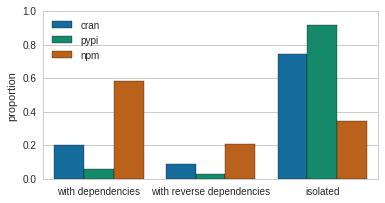

In [34]:
df['with_deps'] = df['pkg_with_deps'] / df['packages']
df['with_rev_deps'] = df['pkg_with_rev_deps'] / df['packages']
df['isolated'] = df['pkg_isolated'] / df['packages']

data = pandas.melt(
    df[['with_deps', 'with_rev_deps', 'isolated']]
      .reset_index()
      .rename(columns={'index': 'ecosystem', 'with_deps': 'with dependencies', 'with_rev_deps': 'with reverse dependencies'}),
    id_vars='ecosystem', 
    value_vars=['with dependencies', 'with reverse dependencies', 'isolated'], 
    var_name='kind', 
    value_name='value')

ax = seaborn.barplot(hue='ecosystem', y='value', x='kind', data=data, hue_order=graphs.keys())
ax.set_xlabel('')
ax.set_ylabel('proportion')
ax.legend(title=None, loc='upper left')

if SHOW_TITLE:
    ax.set_title('Proportion of packages by kind of dependencies')
ax.figure.set_size_inches(FIG_SIZE)

savefig(ax.figure, 'pkg_overview')

In [35]:
df

,avg_deps_by_pkg,pkg_with_rev_deps,pkg_with_deps,dependencies,packages,pkg_non_isolated,pkg_isolated,with_deps,with_rev_deps,isolated
cran,0.394022,872,1921,3770,9568,2449,7119,0.200773,0.091137,0.744043
npm,2.287331,66129,185228,725450,317160,207364,109796,0.584021,0.208504,0.346185
pypi,0.185856,2063,4288,13758,74025,5860,68165,0.057926,0.027869,0.920838


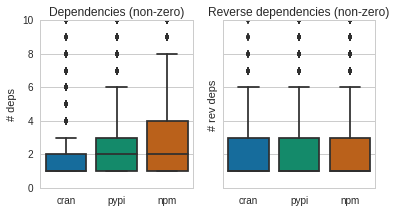

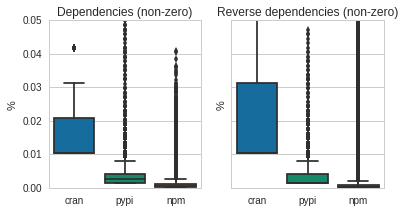

In [36]:
data_in = []
data_in_p = []
data_out = []
data_out_p = []

for ecos, graph in graphs.items():
    n = graph.vcount()
    for d in graph.outdegree():
        if d > 0:
            data_out.append((ecos, d))
            data_out_p.append((ecos, 100 * d / n))
            
    for d in graph.indegree():
        if d > 0:
            data_in.append((ecos, d))
            data_in_p.append((ecos, 100 * d / n))

fig, axes = matplotlib.pyplot.subplots(ncols=2, sharey=True, sharex=True)            

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_out), ax=axes[0])
ax.set_ylim(0, 10)
ax.set_xlabel('')
ax.set_ylabel('# deps')
ax.set_title('Dependencies (non-zero)')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_in), ax=axes[1])
ax.set_ylim(0, 10)
ax.set_xlabel('')
ax.set_ylabel('# rev deps')
ax.set_title('Reverse dependencies (non-zero)')

fig.set_size_inches(FIG_SIZE)
savefig(fig, 'distr_deps')



fig, axes = matplotlib.pyplot.subplots(ncols=2, sharey=True, sharex=True)            

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_out_p), ax=axes[0])
ax.set_ylim(0, 0.05)
ax.set_xlabel('')
ax.set_ylabel('%')
ax.set_title('Dependencies (non-zero)')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_in_p), ax=axes[1])
ax.set_ylim(0, 0.05)
ax.set_xlabel('')
ax.set_ylabel('%')
ax.set_title('Reverse dependencies (non-zero)')

fig.set_size_inches(FIG_SIZE)
savefig(fig, 'distr_deps_relative')

In [37]:
print('Most required packages')
for ecos, graph in graphs.items():
    print(ecos, ':', end=' ')
    for vertex, degree in sorted(zip(graph.vs, graph.indegree()), key=lambda x: x[1], reverse=True)[:10]:
        print('{} ({})'.format(vertex['name'], degree), end=', ')
    print()

print()

print('Most dependent packages')
for ecos, graph in graphs.items():
    print(ecos, ':', end=' ')
    for vertex, degree in sorted(zip(graph.vs, graph.outdegree()), key=lambda x: x[1], reverse=True)[:10]:
        print('{} ({})'.format(vertex['name'], degree), end=', ')
    print()

Most required packages
cran : Rcpp (468), ggplot2 (126), httr (84), dplyr (74), rJava (62), Matrix (55), stringr (51), data.table (49), jsonlite (43), plyr (42), 
pypi : requests (795), numpy (673), six (637), pytest (319), coverage (290), scipy (282), matplotlib (226), pbr (219), pytest-cov (194), mock (193), 
npm : lodash (23306), request (14571), async (14089), underscore (11976), commander (9409), express (9365), chalk (8964), debug (8463), bluebird (7261), mkdirp (6326), 

Most dependent packages
cran : radiant (19), AFM (18), SSDM (15), btergm (14), SurvRank (13), Luminescence (13), toaster (13), hyfo (12), spocc (12), CorReg (11), 
pypi : sentry (98), invenio-records-rest (50), invenio-migrator (49), invenio-openaire (48), invenio-previewer (47), invenio-communities (46), gnocchi (43), invenio-logging (40), cameo (40), invenio-files-rest (39), 
npm : mikolalysenko-hoarders (389), terrible-lodash (309), smasher (130), lodash-modularized (129), compute.io (122), bb-lp-cli (115), s

### Dependencies and transitive dependencies

In [38]:
data = []

for ecos, graph in graphs.items():
    nodes = graph.vs
    for node in nodes: 
        deps = graph.degree(node, mode=igraph.OUT)
        tran_deps = -1  # Ignore source
        for target in graph.bfsiter(node):
            tran_deps += 1
        node['transitive_deps'] = tran_deps
        data.append((ecos, node['name'], deps, tran_deps))

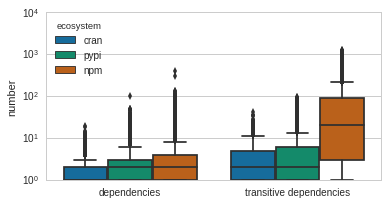

In [39]:
df = pandas.DataFrame(data, columns=['ecosystem', 'package', 'dependencies', 'transitive dependencies'])
df = pandas.melt(df, 
                 id_vars=['ecosystem', 'package'], 
                 value_vars=['dependencies', 'transitive dependencies'],
                 var_name='kind',
                 value_name='value'
                 ).query('value > 0')
ax = seaborn.boxplot(x='kind', y='value', hue='ecosystem', data=df)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('number')
ax.figure.set_size_inches(FIG_SIZE)

if SHOW_TITLE:
    ax.set_title('Number of (transitive) dependencies')
    
savefig(ax.figure, 'deps_distribution')

In [40]:
df = pandas.DataFrame(data, columns=['ecosystem', 'package', 'dependencies', 'transitive dependencies'])

def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / pandas.np.sqrt(pooled_var)
    return d

for kind in ['dependencies', 'transitive dependencies']:
    print(kind)
    for ecos1, ecos2 in itertools.permutations(graphs.keys(), 2):
        temp1 = df.query('ecosystem == "%s"' % ecos1)[kind]
        temp2 = df.query('ecosystem == "%s"' % ecos2)[kind]
    
        score, p_value = scipy.stats.mannwhitneyu(temp1, temp2, alternative='less')
        print('Mann-Whitney-u for {}<{} : {:f} (p-value: {:f})'.format(ecos1, ecos2, score, p_value))
        print('Cohen\'s d: {:f}'.format(CohenEffectSize(temp1, temp2)))
        # score, p_value = scipy.stats.kruskal(temp1, temp2)
        # print('Kruskal-Wallis H-test for {}!={} : {:f} (p-value: {:f})'.format(ecos1, ecos2, score, p_value))
        
    print()

dependencies
Mann-Whitney-u for cran<pypi : 403835561.500000 (p-value: 1.000000)
Cohen's d: 0.155746
Mann-Whitney-u for cran<npm : 870507584.500000 (p-value: 0.000000)
Cohen's d: -0.436385
Mann-Whitney-u for pypi<cran : 304435638.500000 (p-value: 0.000000)
Cohen's d: -0.155746
Mann-Whitney-u for pypi<npm : 5501304903.500000 (p-value: 0.000000)
Cohen's d: -0.524695
Mann-Whitney-u for npm<cran : 2164079295.500000 (p-value: 1.000000)
Cohen's d: 0.436385
Mann-Whitney-u for npm<pypi : 17976464096.500000 (p-value: 1.000000)
Cohen's d: 0.524695

transitive dependencies
Mann-Whitney-u for cran<pypi : 404434405.500000 (p-value: 1.000000)
Cohen's d: 0.153079
Mann-Whitney-u for cran<npm : 828300013.000000 (p-value: 0.000000)
Cohen's d: -0.461706
Mann-Whitney-u for pypi<cran : 303836794.500000 (p-value: 0.000000)
Cohen's d: -0.153079
Mann-Whitney-u for pypi<npm : 5343194725.000000 (p-value: 0.000000)
Cohen's d: -0.510653
Mann-Whitney-u for npm<cran : 2206286867.000000 (p-value: 1.000000)
Cohen's d

### Reverse dependencies and transitive reverse dependencies

In [41]:
data = []

for ecos, graph in graphs.items():
    nodes = graph.vs
    for node in nodes: 
        deps = graph.degree(node, mode=igraph.IN)
        tran_deps = -1  # Ignore source
        for target in graph.bfsiter(node, mode=igraph.IN):
            tran_deps += 1
        node['transitive_rev_deps'] = tran_deps
        data.append((ecos, node['name'], deps, tran_deps))

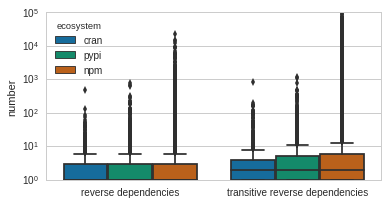

In [42]:
df = pandas.DataFrame(data, columns=['ecosystem', 'package', 'reverse dependencies', 'transitive reverse dependencies'])
df = pandas.melt(df, 
                 id_vars=['ecosystem', 'package'], 
                 value_vars=['reverse dependencies', 'transitive reverse dependencies'],
                 var_name='kind',
                 value_name='value'
                 ).query('value > 0')
ax = seaborn.boxplot(x='kind', y='value', hue='ecosystem', data=df)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('number')
ax.figure.set_size_inches(FIG_SIZE)

if SHOW_TITLE:
    ax.set_title('Number of (transitive) reverse dependencies')
    
savefig(ax.figure, 'rev_deps_distribution')

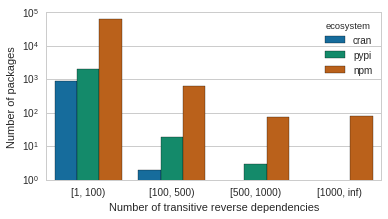

In [43]:
tmp = (df.query('kind == "reverse dependencies"')
  [['ecosystem', 'value']]
  .assign(n=1)
  .groupby(['ecosystem', 'value']).count()
)

bins = [1, 100, 500, 1000, pandas.np.inf]

tmp = (tmp.reset_index()
  .groupby(['ecosystem', pandas.cut(tmp.reset_index()['value'], bins, right=False)])
  .sum()
  [['n']]
  .fillna(0)
  .reset_index()
  #.pivot(index='value', columns='ecosystem', values='n')
)

ax = seaborn.barplot('value', 'n', 'ecosystem', tmp.sort_index(), hue_order=ecosystems)
ax.set_yscale('log')
ax.set_xlabel('Number of transitive reverse dependencies')
ax.set_ylabel('Number of packages')
if SHOW_TITLE:
    ax.set_title('Fragility of the ecosystem')

ax.figure.set_size_inches(FIG_SIZE)
savefig(ax.figure, 'fragility')

In [44]:
tmp.sort_values(['ecosystem', 'value'])

,ecosystem,value,n
0,cran,"[1, 100)",870.0
1,cran,"[100, 500)",2.0
3,cran,"[1000, inf)",0.0
2,cran,"[500, 1000)",0.0
4,npm,"[1, 100)",65337.0
5,npm,"[100, 500)",632.0
7,npm,"[1000, inf)",83.0
6,npm,"[500, 1000)",77.0
8,pypi,"[1, 100)",2041.0
9,pypi,"[100, 500)",19.0


# Package size

(0.0025634765625, 15)

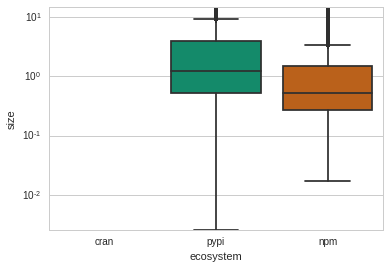

In [45]:
data = []
for ecos, graph in graphs.items():
    for node in graph.vs:
        size = node['size']
        if size != pandas.np.nan:
            data.append((ecos, node['name'], node['size'] / 8 / 1024))
            
df = pandas.DataFrame(data, columns=['ecosystem', 'package', 'size'])
ax = seaborn.boxplot('ecosystem', 'size', data=df)
ax.set_yscale('log')
ax.set_ylim(0, 15)

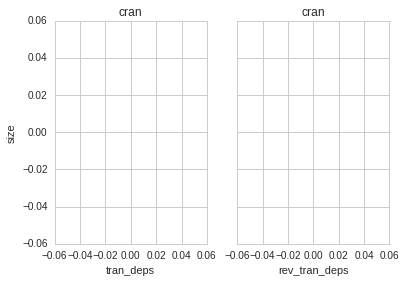

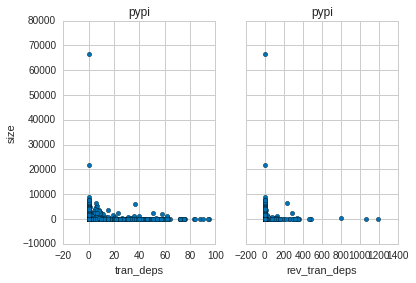

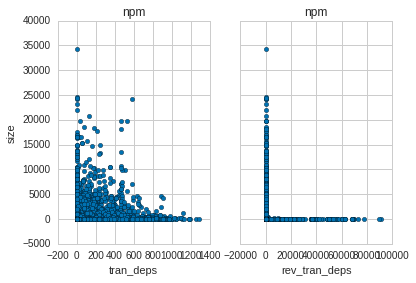

In [46]:
for ecos, graph in graphs.items():
    data = list(zip(graph.vs['name'], graph.vs['size'], graph.vs['transitive_deps'], graph.vs['transitive_rev_deps']))
    df = pandas.DataFrame(data, columns=['package', 'size', 'tran_deps', 'rev_tran_deps'])
    df['size'] = df['size'] / 8 / 1024
    
    fig, (ax_l, ax_r) = matplotlib.pyplot.subplots(ncols=2, sharey=True)
    
    df.plot.scatter('tran_deps', 'size', ax=ax_l)
    df.plot.scatter('rev_tran_deps', 'size', ax=ax_r)
    
    for ax in (ax_l, ax_r):
        ax.set_title(ecos)

## Connected components

In [47]:
data = {ecos: {} for ecos in graphs.keys()}
for ecos, graph in graphs.items():
    for component, size in Counter(len(component) for component in graph.components(mode=igraph.WEAK)).items():
        data[ecos][component] = size
df = pandas.DataFrame.from_dict(data)
print('Number of (weakly) connected components by component size')
df.T.fillna(0)

Number of (weakly) connected components by component size


,1,2,3,4,5,6,7,8,9,10,...,27,28,32,35,36,41,106,2126,5434,201593
cran,7119.0,76.0,30.0,8.0,1.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
npm,109810.0,1486.0,296.0,119.0,40.0,32.0,9.0,11.0,11.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
pypi,68166.0,140.0,14.0,6.0,2.0,3.0,2.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


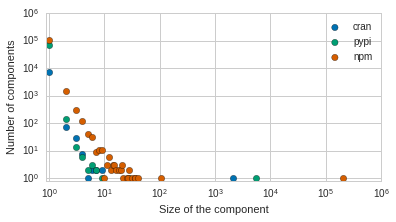

In [48]:
d = df.reset_index().rename(columns={'index': 'component'})
d = pandas.melt(d, id_vars='component', value_vars=['cran', 'npm', 'pypi'], var_name='ecosystem', value_name='size').dropna()

ax = None
for i, ecos in enumerate(graphs.keys()):
    kwargs = {
        'x': 'component', 
        'y': 'size',
        'label': ecos,
        'logx': True,
        'logy': True,
        's': 40,
        'color': COLORS[ecos]
    }
    if ax:
        kwargs['ax'] = ax
        
    ax = d.query('ecosystem == "{}"'.format(ecos)).plot.scatter(**kwargs)
ax.set_xlabel('Size of the component')
ax.set_ylabel('Number of components')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

if SHOW_TITLE:
    ax.set_title('Number of (weakly) connected components by component size')

ax.figure.set_size_inches(FIG_SIZE)
savefig(ax.figure, 'weakly_components')

g = graphs['npm']
clusters = g.clusters(mode=igraph.WEAK)
for component in clusters:
    if len(component) == 106:
        break
subgraph = g.subgraph(component)
n = 0
for line in subgraph.get_adjacency():
    #    print(''.join((str(x) for x in line)))
    n += line[-1]
list(g['name'] for g in subgraph.vs)

In [49]:
data_aspl = []
for ecos, graph in graphs.items():
    clusters = graph.clusters(mode=igraph.WEAK)
    
    for component in tqdm.tqdm(clusters, desc=ecos):
        subgraph = graph.subgraph(component)
        n = subgraph.vcount()
        
        if 1 < n < 200000:
            n_paths = 0
            sum_paths = 0
            for paths in subgraph.shortest_paths_dijkstra(mode=igraph.ALL):
                n_paths += len(paths)
                sum_paths += sum(paths)
            
            data_aspl.append((ecos, n, sum_paths / n_paths))

# NPM's largest component was ignored during the computation here above
# because it takes a while to compute its aspl. The result was previously 
# computed, and is now hard-coded here:
data_aspl.append(('npm', 201593, 4.1))            

npm: 100%|██████████| 111852/111852 [00:43<00:00, 2558.24it/s]


In [50]:
df = pandas.DataFrame.from_records(data_aspl, columns=['ecosystem', 'component', 'aspl'])
df.sort_values('component', ascending=False).groupby('ecosystem').head(5).sort_values('ecosystem')

,ecosystem,component,aspl
0,cran,2126,4.769485
64,cran,9,1.950617
59,cran,9,2.098765
28,cran,7,1.795918
42,cran,7,1.224490
2333,npm,201593,4.100000
901,npm,106,2.580100
1036,npm,41,2.057109
1890,npm,36,2.155864
1260,npm,35,2.894694


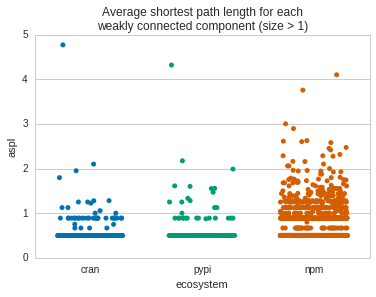

In [51]:
ax = seaborn.stripplot('ecosystem', 'aspl', data=df, jitter=0.3)
ax.set_title('Average shortest path length for each\nweakly connected component (size > 1)')

## Hubs and Authorities

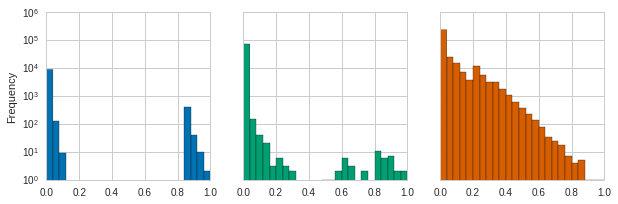

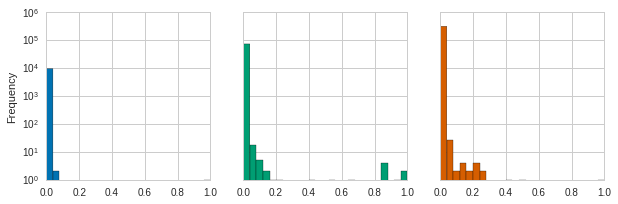

In [52]:
fig_hubs, ax_hubs = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig_hubs.set_size_inches(FIG_SIZE_WIDE)

fig_auth, ax_authorities = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig_auth.set_size_inches(FIG_SIZE_WIDE)

for i, (ecos, graph) in enumerate(graphs.items()):
    hubs, authorities = graph.hub_score(), graph.authority_score()
    hubs, authorities = pandas.Series(hubs), pandas.Series(authorities)
    hubs.plot.hist(label=ecos, ax=ax_hubs[i], bins=25, logy=True, color=COLORS[ecos])
    authorities.plot.hist(label=ecos, ax=ax_authorities[i], bins=25, logy=True, color=COLORS[ecos])
    if SHOW_TITLE:
        ax_hubs[i].set_title('Hubs for {}'.format(ecos))
        ax_authorities[i].set_title('Authorities for {}'.format(ecos))
    
savefig(fig_hubs, 'hubs')
savefig(fig_auth, 'auths')

## Pagerank

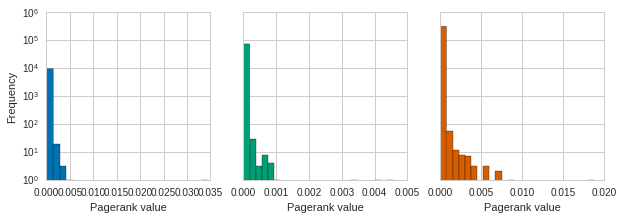

In [53]:
fig, axes = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

for i, (ecos, graph) in enumerate(graphs.items()):
    pagerank = graph.pagerank()
    pandas.Series(pagerank).plot.hist(label=ecos, ax=axes[i], bins=25, logy=True, color=COLORS[ecos])
    if SHOW_TITLE:
        axes[i].set_title(ecos)
    axes[i].set_xlabel('Pagerank value')
    
savefig(fig, 'pagerank')